In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Load data

In [2]:
df = pd.read_csv("Concrete_Data_2.csv", ";")

df = df.astype('float32')

pd.options.display.float_format = '{:,.2f}'.format
df.apply(lambda x: x.astype(int) if np.allclose(x, x.astype(int)) else x)
df = df.drop(columns="6.00")

df_src = df.loc[0:600,:]
#print(df_src.head(), df_src.shape)

df_tar = df.loc[601:1000,:]
#print(df_tar.head(), df_tar.shape)

In [3]:
# source
Xs = df_src.iloc[:,:-1]
Ys = df_src.iloc[:,-1]

# target_train
Xt = df_tar.iloc[:,:-1]
Yt = df_tar.iloc[:,-1]

BDA iteration [1/10]: MSE: 161.1632
BDA iteration [2/10]: MSE: 161.1632
BDA iteration [3/10]: MSE: 161.1632
BDA iteration [4/10]: MSE: 161.1632
BDA iteration [5/10]: MSE: 161.1632
BDA iteration [6/10]: MSE: 161.1632
BDA iteration [7/10]: MSE: 161.1632
BDA iteration [8/10]: MSE: 161.1632
BDA iteration [9/10]: MSE: 161.1632
BDA iteration [10/10]: MSE: 161.1632
The MSE of BDA is: 161.1632


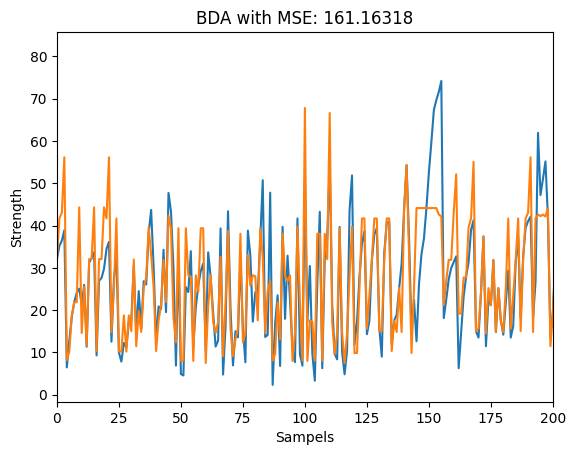

In [15]:
from TL_Regression_Methods.BDA import BDA

bda = BDA(kernel_type='primal', dim=30, lamb=1, mu=0.5, mode='BDA', gamma=1, estimate_mu=False)
acc, ypre, list_acc = bda.fit_predict(Xs, Ys, Xt, Yt)
print(f'The MSE of BDA is: {acc:.4f}')

plt.plot(Yt.reset_index(drop=True))
plt.plot(ypre)
plt.xlim(0, 200)
plt.title('BDA with MSE: '+ str(acc))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

# ISt so implementiert das es so viele Durchläufe gibt wie Klassen 

The accuracy of JDA is: 111.8814


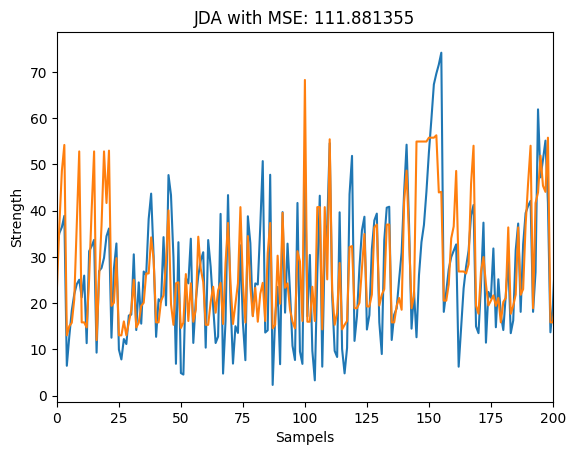

In [17]:
from TL_Regression_Methods.JDA import JDA

jda = JDA(kernel_type='primal', dim=30, lamb=1, gamma=1)
acc, ypre, list_acc = jda.fit_predict(Xs, Ys, Xt, Yt)
print(f'The accuracy of JDA is: {acc:.4f}')

plt.plot(Yt.reset_index(drop=True))
plt.plot(ypre)
plt.xlim(0, 200)
plt.title('JDA with MSE: '+ str(acc))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

The MSE of JDA is: 358.4248


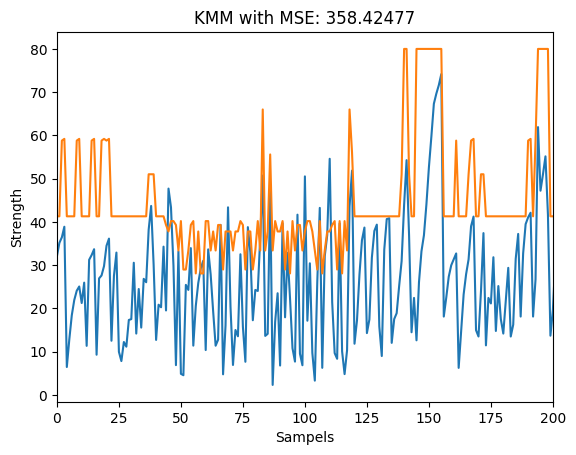

In [16]:
from TL_Regression_Methods.CORAL import CORAL

coral = CORAL()
k = 1
acc, ypre = coral.fit_predict(Xs, Ys, Xt, Yt, k)
print(f'The MSE of JDA is: {acc:.4f}')

plt.plot(Yt.reset_index(drop=True))
plt.plot(ypre)
plt.xlim(0, 200)
plt.title('KMM with MSE: '+ str(acc))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

In [20]:
from TL_Regression_Methods.KMM import KMM
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

model = KNeighborsRegressor(n_neighbors=7)
model.fit(Xs, Ys)
Yt_pred = model.predict(Xt)
acc = mean_squared_error(Yt, Yt_pred)
print(f'MSE using KMM: {acc:.2f}')

plt.plot(Yt.reset_index(drop=True))
plt.plot(Yt_pred)
plt.xlim(0, 200)
plt.title('KMM with MSE: '+ str(acc))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

ImportError: cannot import name 'KMM' from 'TL_Regression_Methods.KMM' (c:\Users\lemaye\Desktop\GitHub\BA_transfer_learning\TL_Regression_Methods\KMM.py)

In [29]:
from TL_Regression_Methods.TwoStageTrAdaBoostR2 import TwoStageTrAdaBoostR2
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

X = np.concatenate((Xs, Xt.loc[120:]))
y = np.concatenate((Ys, Yt.loc[120:]))
sample_size = [len(df_src), len(df_tar)]

n_estimators = 80
steps = 10
fold = 5
random_state = np.random.RandomState(1)

regr_1 = TwoStageTrAdaBoostR2(DecisionTreeRegressor(max_depth=8),
                      n_estimators = n_estimators, sample_size = sample_size, 
                      steps = steps, fold = fold, 
                      random_state = random_state)
regr_1.fit(X, y)
y_pred1 = regr_1.predict(Xt.loc[121:150,:])

In [ ]:
#BDA
bda = BDA(kernel_type='primal', dim=30, lamb=1, mu=0.5, mode='BDA', gamma=1, estimate_mu=False)
mse_bda, ypre_bda, list_acc = bda.fit_predict(Xs, Ys, Xt, Yt)

#JDA
jda = JDA(kernel_type='primal', dim=30, lamb=1, gamma=1)
mse_jda, ypre_jda, list_acc = jda.fit_predict(Xs, Ys, Xt, Yt)

#Coral
coral = CORAL()
k = 1
mse_cor, ypre_cor = coral.fit_predict(Xs, Ys, Xt, Yt, k)

#KMM
model = KNeighborsRegressor(n_neighbors=7)
model.fit(Xs, Ys)
ypre_kmm = model.predict(Xt)
mse_kmm = sklearn.metrics.mean_squared_error(Yt, ypre_kmm)


print(f'The MSE of BDA is: {mse_bda:.4f}')
print(f'The MSE of JDA is: {mse_jda:.4f}')
print(f'The MSE of JDA is: {mse_cor:.4f}')
print(f'The MSE of KMM is: {mse_kmm:.2f}')

# Create four polar axes and access them through the returned array
fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(ypre_bda)
ax[0, 1].plot(ypre_cor)
ax[1, 0].plot(ypre_kmm)
ax[1, 1].plot(ypre_jda)
ax[0, 0].plot(Yt.reset_index(drop=True))
ax[0, 1].plot(Yt.reset_index(drop=True))
ax[1, 0].plot(Yt.reset_index(drop=True))
ax[1, 1].plot(Yt.reset_index(drop=True))
ax[0, 0].set_xlim([50, 100])
ax[0, 1].set_xlim([50, 100])
ax[1, 0] .set_xlim([50, 100])
ax[1, 1].set_xlim([50, 100])

#ax.set_xlabel('Sampels')
#ax.set_ylabel('Strength')

plt.show()